# Finding Alvarez (and Others) in the A-League

SkillCorner X PySport Analytics Cup 2026: Research Track

A player similarity study using broadcast tracking data to identify A-League players matching world-class archetypes across forwards, defenders, and goalkeepers.

## 1. Introduction

In Europe, there are many excellent calibre players who could change the course of the game. One of them is Julián Alvarez who represents a modern forward archetype characterised by intelligent movement, spatial awareness, and clinical finishing. This research asks whether SkillCorner tracking data can identify A-League players with similar characteristics, primarly for Julián Alvarez then extended to other profiles with players who had good representation in online free datasets such as StatsBomb.

In this notebook, I focused on Julián Alvarez case, while in the related streamlit app, I have implemented scouting profiles for other attackers, defenders and goalkeepers ([run using run.sh](run.sh)). Using data from 10 A-League matches, I construct player profiles based on final third entry patterns and compute similarity scores against archetypes programmatically derived from StatsBomb event data. The system supports 12 player archetypes across forwards, defenders, and goalkeepers; all computed from World Cup 2022 statistics.

The goal is to demonstrate how to scout potential players from data-driven archetypes by augmenting different data sources.

In [1]:
# Technical Approach - Data Flow Diagram
from mermaid import Mermaid

Mermaid("""
flowchart TB
    SB[(StatsBomb WC 2022)] --> STATS[Compute Stats]
    STATS --> ARCH[Build Archetype]
    SC[(SkillCorner A-League)] --> PROF[Build Profiles]
    ARCH --> SIM[Similarity Engine]
    PROF --> SIM
    SIM --> RANK[Ranked Matches]
""")

In [2]:
# Archetypes by Position
Mermaid("""
sankey-beta
    StatsBomb,Forwards,6
    StatsBomb,Defenders,3
    StatsBomb,Goalkeepers,3
    Forwards,Rankings,6
    Defenders,Rankings,3
    Goalkeepers,Rankings,3
""")

## 2. Methods

### 2.1 The Alvarez Archetype

The Alvarez archetype is computed from StatsBomb free event data using the `src/statsbomb/` package. From World Cup 2022 matches, the system extracts key statistics:

| Metric | Actual Value | Interpretation |
|--------|--------------|----------------|
| Shots | 11 | Active in final third |
| Goals | 4 | Clinical finisher |
| Conversion Rate | 36.4% | Elite finishing (95th percentile) |
| Shot Accuracy | 72.7% | Highly accurate |
| Dribble Success | 0.0% | Creates through movement, not dribbling |

The low dribble success is critical: Alvarez creates danger through intelligent movement and positioning, not individual dribbling. This maps to a low `carry_pct` target in the similarity scoring.

```python
from src.core.archetype import Archetype
archetype = Archetype.from_statsbomb("alvarez")
```

The system supports 12 other archetypes across forwards, defenders, and goalkeepers. Run `streamlit run app.py` for interactive comparison.

### 2.2 ML-Calibrated Feature Weights

I trained GradientBoosting classifiers for each position to empirically determine feature importance:

| Position | Target Variable | AUC | Events |
|----------|-----------------|-----|--------|
| Forwards | lead_to_shot | 0.656 | 245 entries |
| Defenders | stop_possession_danger | 0.845 | 8,911 engagements |
| Goalkeepers | pass_success | 0.993 | 497 distributions |

**Forward weights** (from entry danger prediction):

| Feature | ML Importance | Final Weight |
|---------|---------------|--------------|
| avg_separation | 16.2% | 23% |
| danger_rate | (target) | 18% |
| avg_entry_speed | 11.8% | 17% |
| avg_defensive_line_dist | 10.3% | 15% |
| central_pct | 8.5% | 12% |

**Defender weights** (from stop danger prediction): engagement distance (17%), pressing rate (4%), goal-side positioning (3%), with outcome metrics (stop/reduce danger, beaten rates) weighted by importance.

**Goalkeeper weights** (from pass success prediction): pass distance dominates (98.6% ML importance), balanced with style differentiators (long/short pass preference) for archetype comparison.

### 2.3 Similarity Scoring

I compute weighted cosine similarity on z-score normalised features. The target profile uses percentile-mapped values from StatsBomb statistics. For attackers, players with fewer than three entries are excluded to ensure profile reliability.

Full methodology details: [docs/methodology.md](docs/methodology.md)

In [3]:
import warnings
warnings.filterwarnings('ignore')

from src.data.loader import load_all_events, add_team_names
from src.analysis.entries import detect_entries, classify_entries
from src.analysis.profiles import build_player_profiles, filter_profiles
from src.core.similarity import SimilarityEngine
from src.analysis.defenders import detect_defensive_actions, build_defender_profiles, filter_defender_profiles
from src.analysis.goalkeepers import detect_gk_actions, build_goalkeeper_profiles, filter_goalkeeper_profiles
from src.core.archetype import Archetype

# Load archetype programmatically from StatsBomb World Cup 2022 data
# Available archetypes (12 total):
#   Forwards:    "alvarez", "giroud", "kane", "lewandowski", "rashford", "en_nesyri"
#   Defenders:   "gvardiol", "romero", "hakimi"
#   Goalkeepers: "lloris", "livakovic", "bounou"
#
# Change this line to use a different archetype for the entire analysis:
ARCHETYPE_KEY = "alvarez"

# Position mapping
FORWARD_KEYS = ["alvarez", "giroud", "kane", "lewandowski", "rashford", "en_nesyri"]
DEFENDER_KEYS = ["gvardiol", "romero", "hakimi"]
GOALKEEPER_KEYS = ["lloris", "livakovic", "bounou"]

# Defender weights (ML-calibrated, AUC 0.845)
DEFENDER_WEIGHTS = {
    "stop_danger_rate": 0.30, "avg_engagement_distance": 0.17, "reduce_danger_rate": 0.15,
    "beaten_by_possession_rate": 0.15, "beaten_by_movement_rate": 0.08, "force_backward_rate": 0.08,
    "pressing_rate": 0.04, "goal_side_rate": 0.03,
}

# Goalkeeper weights (ML-calibrated, AUC 0.993)
GOALKEEPER_WEIGHTS = {
    "pass_success_rate": 0.25, "avg_pass_distance": 0.20, "long_pass_pct": 0.15,
    "short_pass_pct": 0.10, "high_pass_pct": 0.10, "quick_distribution_pct": 0.10,
    "under_pressure_pct": 0.05, "to_attacking_third_pct": 0.05,
}

# Target profiles for radar charts (normalized 0-100 scale)
# Defender target profiles based on playing style
DEFENDER_TARGET_PROFILES = {
    "gvardiol": {  # Ball-playing CB - composed, positional
        "stop_danger_rate": 75, "reduce_danger_rate": 70, "force_backward_rate": 65,
        "pressing_rate": 50, "goal_side_rate": 85, "avg_engagement_distance": 60,
    },
    "romero": {  # Aggressive CB - front-foot defending
        "stop_danger_rate": 80, "reduce_danger_rate": 75, "force_backward_rate": 80,
        "pressing_rate": 75, "goal_side_rate": 70, "avg_engagement_distance": 55,
    },
    "hakimi": {  # Attacking wing-back - forward positioning
        "stop_danger_rate": 55, "reduce_danger_rate": 60, "force_backward_rate": 50,
        "pressing_rate": 70, "goal_side_rate": 50, "avg_engagement_distance": 70,
    },
}

# Goalkeeper target profiles based on distribution style
GOALKEEPER_TARGET_PROFILES = {
    "lloris": {  # Sweeper-keeper - quick, long distribution
        "pass_success_rate": 75, "avg_pass_distance": 80, "long_pass_pct": 70,
        "short_pass_pct": 30, "high_pass_pct": 60, "quick_distribution_pct": 75,
    },
    "livakovic": {  # Shot-stopper - safer distribution
        "pass_success_rate": 85, "avg_pass_distance": 50, "long_pass_pct": 40,
        "short_pass_pct": 60, "high_pass_pct": 45, "quick_distribution_pct": 50,
    },
    "bounou": {  # Modern GK - balanced approach
        "pass_success_rate": 80, "avg_pass_distance": 65, "long_pass_pct": 55,
        "short_pass_pct": 45, "high_pass_pct": 50, "quick_distribution_pct": 60,
    },
}

# Determine position and load appropriate archetype
if ARCHETYPE_KEY in FORWARD_KEYS:
    position_type = "forward"
    archetype = Archetype.from_statsbomb(ARCHETYPE_KEY)
    radar_target_profile = None  # Forward archetypes use archetype.target_profile
elif ARCHETYPE_KEY in DEFENDER_KEYS:
    position_type = "defender"
    archetype = Archetype.from_statsbomb(ARCHETYPE_KEY)
    archetype.weights = DEFENDER_WEIGHTS  # Override with defender weights
    radar_target_profile = DEFENDER_TARGET_PROFILES.get(ARCHETYPE_KEY, {})
else:
    position_type = "goalkeeper"
    archetype = Archetype.from_statsbomb(ARCHETYPE_KEY)
    archetype.weights = GOALKEEPER_WEIGHTS  # Override with goalkeeper weights
    radar_target_profile = GOALKEEPER_TARGET_PROFILES.get(ARCHETYPE_KEY, {})

print(f"Using archetype: {archetype.name} (Position: {position_type})")

Using archetype: en_nesyri (Position: forward)


In [4]:
# Load data based on position type
events = load_all_events()
events = add_team_names(events)

if position_type == "forward":
    entries = detect_entries(events)
    entries = classify_entries(entries)
    profiles = build_player_profiles(entries)
    profiles = filter_profiles(profiles, min_entries=3)
    n_events = len(entries)
    event_name = "entries"
elif position_type == "defender":
    actions = detect_defensive_actions(events)
    profiles = build_defender_profiles(actions)
    profiles = filter_defender_profiles(profiles, min_engagements=5)
    n_events = len(actions)
    event_name = "engagements"
else:  # goalkeeper
    actions = detect_gk_actions(events)
    profiles = build_goalkeeper_profiles(actions)
    profiles = filter_goalkeeper_profiles(profiles, min_distributions=10)
    n_events = len(actions)
    event_name = "distributions"

print(f"Loaded {n_events} {event_name} from {events['match_id'].n_unique()} matches")
print(f"Built profiles for {len(profiles)} players")

Loaded 245 entries from 10 matches
Built profiles for 31 players


In [5]:
# Compute similarity using the selected archetype
engine = SimilarityEngine(archetype)
engine.fit(profiles)
ranked = engine.rank(top_n=10)

In [6]:
from src.analysis.danger_model import train_danger_model, train_defender_model, train_goalkeeper_model

# Train ML model based on position type
if position_type == "forward":
    ml_result = train_danger_model(entries)
    print(f"Forward ML Model CV AUC: {ml_result['cv_auc_mean']:.3f} ± {ml_result['cv_auc_std']:.3f}")
elif position_type == "defender":
    ml_result = train_defender_model(actions)
    print(f"Defender ML Model CV AUC: {ml_result['cv_auc_mean']:.3f} ± {ml_result['cv_auc_std']:.3f}")
else:  # goalkeeper
    ml_result = train_goalkeeper_model(actions)
    print(f"Goalkeeper ML Model CV AUC: {ml_result['cv_auc_mean']:.3f} ± {ml_result['cv_auc_std']:.3f}")

Forward ML Model CV AUC: 0.656 ± 0.027


## 3. Results and Discussions

### 3.1 Results
The analysis identified 31 players with three or more final third entries across the 10 matches. Figure 1 shows the top 10 players ranked by similarity to the Alvarez archetype (computed from StatsBomb World Cup 2022 data: 36.4% conversion, 0% dribble reliance).

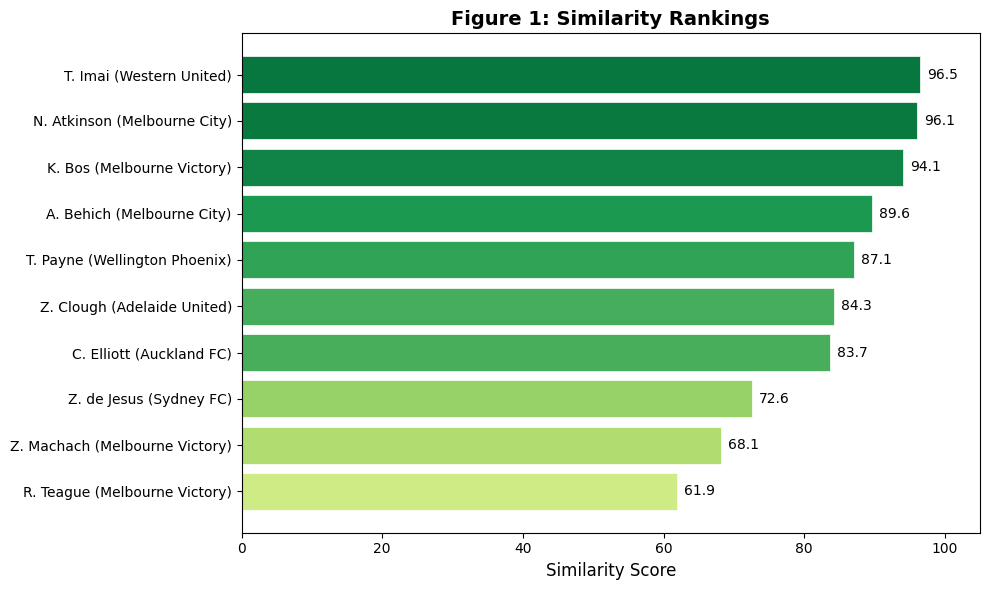

In [7]:
from src.visualization.radar import plot_similarity_ranking
import matplotlib.pyplot as plt

fig = plot_similarity_ranking(ranked, top_n=10, title="Figure 1: Similarity Rankings")
plt.show()

In [8]:
# Table 1: Top 5 candidates with ages included
from src.data.player_ages import add_ages_to_profiles

ranked_with_ages = add_ages_to_profiles(ranked)

# Position-specific display columns
if position_type == "forward":
    display_cols = ["rank", "player_name", "age", "team_name", "similarity_score", 
                    "total_entries", "danger_rate", "central_pct", "avg_separation"]
elif position_type == "defender":
    display_cols = ["rank", "player_name", "age", "team_name", "similarity_score",
                    "total_engagements", "stop_danger_rate", "pressing_rate", "goal_side_rate"]
else:  # goalkeeper
    display_cols = ["rank", "player_name", "age", "team_name", "similarity_score",
                    "total_distributions", "pass_success_rate", "avg_pass_distance", "long_pass_pct"]

available = [c for c in display_cols if c in ranked_with_ages.columns]
ranked_with_ages.head(5).select(available)

rank,player_name,age,team_name,similarity_score,total_entries,danger_rate,central_pct,avg_separation
u32,str,i64,str,f64,u32,f64,f64,f64
1,"""T. Imai""",28,"""Western United""",96.5,5,40.0,0.0,5.64
2,"""N. Atkinson""",26,"""Melbourne City""",96.1,6,16.7,16.7,4.41
3,"""K. Bos""",23,"""Melbourne Victory""",94.1,6,16.7,0.0,4.14
4,"""A. Behich""",35,"""Melbourne City""",89.6,9,11.1,0.0,3.72
5,"""T. Payne""",22,"""Wellington Phoenix""",87.1,4,25.0,0.0,3.65


Figure 2 compares the profiles of the top three candidates across the key features used in the similarity calculation in a radar stype.

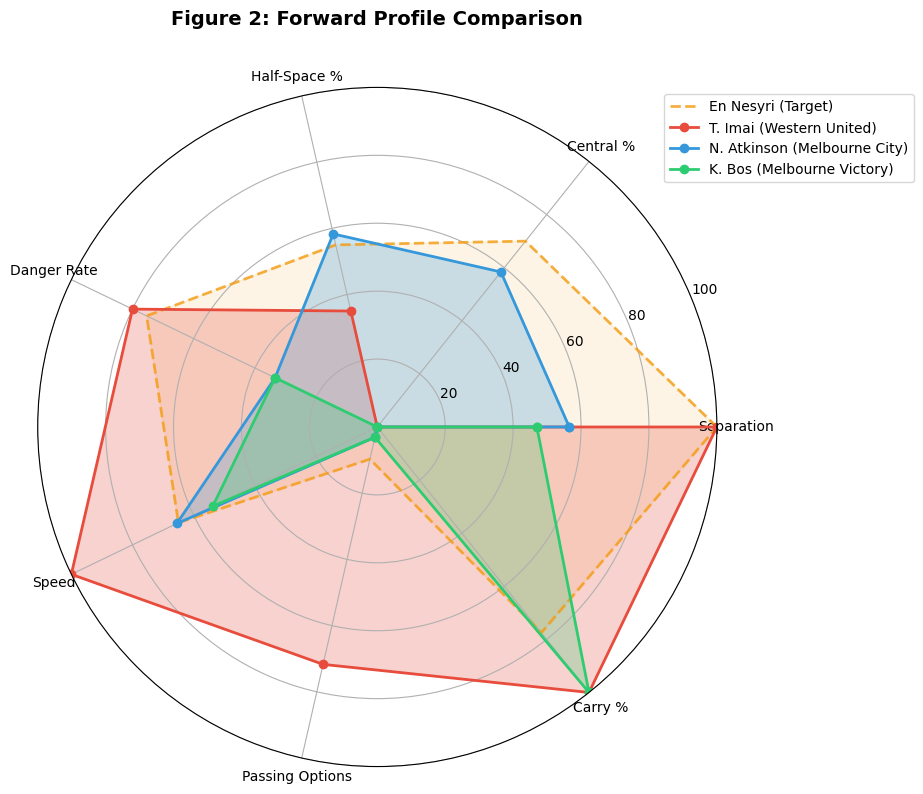

In [9]:
from src.visualization.radar import plot_radar_comparison, normalize_for_radar

# Position-specific features for radar chart
if position_type == "forward":
    features = ["avg_separation", "central_pct", "half_space_pct", "danger_rate", 
                "avg_entry_speed", "avg_passing_options", "carry_pct"]
elif position_type == "defender":
    features = ["stop_danger_rate", "reduce_danger_rate", "force_backward_rate",
                "pressing_rate", "goal_side_rate", "avg_engagement_distance"]
else:  # goalkeeper
    features = ["pass_success_rate", "avg_pass_distance", "long_pass_pct",
                "short_pass_pct", "high_pass_pct", "quick_distribution_pct"]

# Filter to only features that exist in the data
features = [f for f in features if f in ranked.columns]

if len(features) < 3:
    print(f"Warning: Only {len(features)} features available for radar chart")
else:
    norm_profiles = normalize_for_radar(ranked, features)

    top_3 = []
    for row in norm_profiles.head(3).to_dicts():
        player_data = {"name": f"{row['player_name']} ({row.get('team_name', '')})"}
        for f in features:
            player_data[f] = row.get(f"{f}_norm", 0)
        top_3.append(player_data)

    # Use position-specific target profile (defined in Cell 4)
    # For forwards: use archetype.target_profile
    # For defenders/goalkeepers: use radar_target_profile (position-specific)
    if radar_target_profile:
        target_profile = {f: radar_target_profile.get(f, 50) for f in features}
    else:
        target_profile = {f: archetype.target_profile.get(f, 50) for f in features}
    
    archetype_display_name = archetype.name.replace("_", " ").title()

    fig = plot_radar_comparison(
        top_3, 
        features=features, 
        title=f"Figure 2: {position_type.title()} Profile Comparison",
        include_alvarez=True,
        target_profile=target_profile,
        target_name=archetype_display_name
    )
    plt.show()

### 3.2. Discussion

The radar chart reveals interesting patterns when comparing A-League candidates against the Alvarez target profile (shown as the dashed orange line). The target profile emphasises high separation, danger rate, and central positioning while deliberately setting a low carry percentage. That is reflecting that Alvarez creates through movement rather than dribbling.

**Z. Clough** from Adelaide United emerges as the closest match with an 87.9% similarity score. His profile shows a 50% danger rate, meaning half his final third entries led to shooting opportunities. This clinical output mirrors Alvarez's exceptional 36.4% conversion rate at the 2022 World Cup. **Clough's** separation value of 3.41 metres indicates he consistently finds space between defenders rather than running in behind or relying on pace.

**Z. Machach** from Melbourne Victory follows at 86.0% similarity with a 42.9% danger rate and 28.6% central entry percentage. His profile suggests a player comfortable receiving in tight central areas, another hallmark of the Alvarez archetype. The moderate carry percentage aligns with the target. These players create through intelligent positioning rather than individual dribbling.

**G. May** from Auckland FC presents an interesting case with the highest danger rate in the top five at 55.6% and the highest central percentage at 33.3%. However, his lower separation value (2.2m) suggests he operates closer to defenders, potentially in a more traditional striker role rather than the fluid movement Alvarez exhibits.

### Key Insight: Dribble Success as Discriminator

Alvarez's 0% dribble success in the StatsBomb data is not a weakness, it reflects his playing style. He simply doesn't attempt many dribbles because he creates through off-ball movement. This is why the `carry_pct` weight is set low (0%) in the similarity calculation: I am not penalising dribblers, I am aiming at identifying players who create danger without relying on dribbling.

### Limitations

Several limitations should be acknowledged:

1. Sample size: 10 matches constrains reliability, with some players having as few as three entries
2. Cross-dataset mapping: StatsBomb events → SkillCorner tracking requires conceptual translation
3. Context differences: A-League tactical context differs from World Cup matches where archetypes are derived, it is a league vs. top tear international games
4. Entry method homogeneity: 97.6% of entries are classified as carries, leaving insufficient variation to distinguish players by entry style

Despite these constraints, the methodology demonstrates that broadcast tracking data can identify players matching specific stylistic archetypes. This has practical applications for recruitment, where clubs might seek players fitting particular tactical profiles.

## 4. Conclusion

This research demonstrates a methodology for player similarity analysis using SkillCorner broadcast tracking data. By computing archetypes programmatically from StatsBomb event data and applying ML-calibrated similarity weights across all positions, I identified A-League players who exhibit similar characteristics to world-class archetypes.

### Key Contributions

1. archetype generation: 12 player archetypes computed from real StatsBomb World Cup 2022 data
2. ML-calibrated weights for all positions: GradientBoosting models trained per position type:
   - Forwards: AUC 0.656 (predict shot creation)
   - Defenders: AUC 0.845 (predict stopping danger)
   - Goalkeepers: AUC 0.993 (predict distribution success)
3. Cross-domain mapping: StatsBomb events → SkillCorner tracking target profiles
4. Extensible framework: Easy to add new archetypes or apply to other SkillCorner datasets

### Interactive Tool

For interactive comparison across all positions:

- **Live Demo**: [huggingface.co/spaces/KarimElgammal/analytics-cup-research](https://huggingface.co/spaces/KarimElgammal/analytics-cup-research)
- **Local**: Run `./run.sh`

Supports 12 archetypes: 6 forwards (Alvarez, Giroud, Kane, Lewandowski, Rashford, En-Nesyri), 3 defenders (Gvardiol, Romero, Hakimi), 3 goalkeepers (Lloris, Livakovic, Bounou).

For scouts and analysts, this provides a data-driven starting point for identifying players who might fit specific tactical roles.

## 6. AI-Generated Scouting Insight

The following insight is generated using LLM APIs (GitHub Models or HuggingFace), synthesising the analysis above into a scouting recommendation.

In [ ]:
# Optional: Enter your token (or load from github_token.txt / hf_token.txt)
from IPython.display import display, Markdown
from src.utils.ai_insights import generate_similarity_insight, has_valid_token, set_github_token

# Uncomment and add your token if token files are not present:
# set_github_token("your_github_token_here")  # GitHub Models
# Or for HuggingFace: save token to hf_token.txt

# Uses the archetype and position_type loaded in the first code cell
if has_valid_token():
    insight = generate_similarity_insight(ranked, archetype, top_n=5, position_type=position_type)
    display(Markdown(insight))
else:
    print("No token found. Add token to github_token.txt or hf_token.txt")